In [1]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 62.6 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=a36237f2c08411e5ec1cac425a9579e9dc90691799c0fcd83d56494f2843fdd4
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=5c909f4b14bcb8e8682422aeeca82c1b5db4035bacbdce1d9672f6f6a9d66612
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel f

# 影片轉tensor

In [17]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import center_crop

# === 設定 ===
video_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S"
save_dir = os.path.join(video_dir, "tensors_x3d")
os.makedirs(save_dir, exist_ok=True)

# === 前處理參數 ===
NUM_FRAMES = 13
RESIZE_SIZE = 160
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])

# === 影片 → Tensor 函數 ===
def video_to_tensor(video_path, num_frames=NUM_FRAMES, size=RESIZE_SIZE):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = center_crop(frame, size)
        frame = frame.resize((size, size))  # (H, W)
        frames.append(transform(frame))  # → (C, H, W)

    cap.release()
    if len(frames) != num_frames:
        return None  # 忽略長度不足的影片

    video_tensor = torch.stack(frames, dim=1)  # (C, T, H, W)
    return video_tensor

# === 批次處理所有影片 ===
video_list = sorted([f for f in os.listdir(video_dir) if f.endswith(".mp4")])
for video_file in tqdm(video_list, desc="Processing videos"):
    video_path = os.path.join(video_dir, video_file)
    tensor = video_to_tensor(video_path)
    if tensor is not None:
        save_path = os.path.join(save_dir, video_file.replace(".mp4", ".pt"))
        torch.save(tensor, save_path)


Processing videos: 100%|██████████| 382/382 [25:00<00:00,  3.93s/it]


# 整理成X,Y

In [18]:
import os
import torch
import pandas as pd
from tqdm import tqdm

# === 路徑設定 ===
tensor_dir = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/tensors_x3d"
csv_path = "/content/drive/MyDrive/Baseball Movies/釀酒人主場videos_4S/Milwaukee_Brewers_FF_videos_4S/Milwaukee_Brewers_FF.csv"

# === 讀取 CSV：建立 filename → description 的對應字典 ===
df = pd.read_csv(csv_path)
label_dict = dict(zip(df["Filename"], df["description"]))  # e.g., {"pitch_0001.mp4": "strike"}

# === 讀取所有 .pt 檔案，並對應回 label ===
X = []
y = []

tensor_files = sorted([f for f in os.listdir(tensor_dir) if f.endswith(".pt")])
for pt_file in tqdm(tensor_files, desc="Loading tensors"):
    mp4_filename = pt_file.replace(".pt", ".mp4")

    if mp4_filename not in label_dict:
        print(f"⚠️ {mp4_filename} not found in CSV, skipping.")
        continue

    tensor_path = os.path.join(tensor_dir, pt_file)
    video_tensor = torch.load(tensor_path)  # (3, T, H, W)

    label = label_dict[mp4_filename]

    X.append(video_tensor)
    y.append(label)  # or use label_map[label] if you want to map to integers

print(f"✅ Loaded {len(X)} samples")


Loading tensors: 100%|██████████| 382/382 [00:06<00:00, 60.33it/s]

✅ Loaded 382 samples


# 將y做encoding

In [20]:
y = [1 if "strike" in label.lower() else 0 for label in y]

# 看一下X shape

In [26]:
print(X[0].shape)

torch.Size([3, 13, 160, 160])


# 準備 X3D 模型（二分類）

In [28]:
import torch.nn as nn
from pytorchvideo.models.hub import x3d_xs

device = "cuda" if torch.cuda.is_available() else "cpu"

model = x3d_xs(pretrained=False)
model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # 二分類
model = model.to(device)


# 訓練流程（含 train/val/test + 混淆矩陣）

🔧 1. 分割資料集

In [30]:
from sklearn.model_selection import train_test_split

# 先轉成 numpy array 才能 split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)


📦 2. 包成 Dataset 和 DataLoader

In [31]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(VideoDataset(X_train, y_train), batch_size=4, shuffle=True)
val_loader   = DataLoader(VideoDataset(X_val, y_val),     batch_size=4, shuffle=False)
test_loader  = DataLoader(VideoDataset(X_test, y_test),   batch_size=4, shuffle=False)


🧠 3. 建立模型與訓練設定

In [32]:
import torch.nn as nn
from pytorchvideo.models.hub import x3d_xs
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = x3d_xs(pretrained=False)
model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


🏃 4. 訓練＋驗證迴圈

In [37]:
from tqdm.notebook import tqdm
import gc
def evaluate(model, dataloader):
    model.eval()
    correct, total, loss_total = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_total / len(dataloader), correct / total

# === Training Loop ===
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        gc.collect()

    train_acc = correct / total
    val_loss, val_acc = evaluate(model, val_loader)
    gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 39.1222 | Train Acc: 0.7445 | Val Loss: 0.6737 | Val Acc: 0.6667


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 39.1178 | Train Acc: 0.7445 | Val Loss: 0.6738 | Val Acc: 0.6667


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 39.1190 | Train Acc: 0.7445 | Val Loss: 0.6739 | Val Acc: 0.6667


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 39.1168 | Train Acc: 0.7445 | Val Loss: 0.6740 | Val Acc: 0.6667


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 39.3659 | Train Acc: 0.7445 | Val Loss: 0.6740 | Val Acc: 0.6667


📊 5. 測試集混淆矩陣

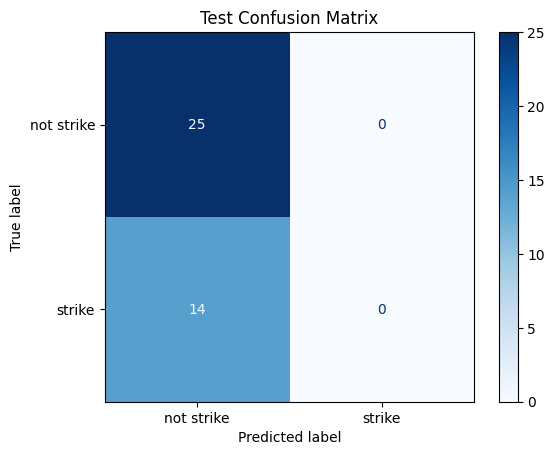

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 推論 test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# 畫混淆矩陣
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not strike", "strike"])
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

In [ ]:
import nbformat
from google.colab import files

# 讀入目前的 notebook（必須手動指定名稱）
NOTEBOOK_NAME = "your_notebook.ipynb"  # <-- 修改成你實際的檔名

with open(NOTEBOOK_NAME, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# 移除 widgets metadata
nb["metadata"].pop("widgets", None)

# 儲存為新的檔案
FIXED_NAME = "fixed_" + NOTEBOOK_NAME
with open(FIXED_NAME, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

# 下載修復後的 notebook
files.download(FIXED_NAME)
